## **Utility function**

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd
import splitfolders
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import re
import gc
import glob
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
import datetime
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Activation, BatchNormalization
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
import torch
import random
import itertools

**Check the runtime type**

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#split the files into folders
def split():
    data_dir = os.path.join('/content/drive/MyDrive/binary_data/data')
    print("No of images in each class of data directory")
    for dir, subdir, files in os.walk(data_dir):
        print(dir,':', str(len(files)))
        
    splitfolders.ratio("/content/drive/MyDrive/binary_data/data", 
                       output = "/content/drive/MyDrive/binary_data_folders",
                       seed = 6, 
                       ratio = (0.8, 0.2), 
                       group_prefix = None, 
                       move = False)

if os.path.exists("/content/drive/MyDrive/binary_data_folders"):
    print("Files already present in splitted ratio 0.8, 0.2")
else:
    split()
    print("Files are splitted in the ratio 0.8, 0.2")

Files already present in splitted ratio 0.8, 0.2


In [ ]:
train = '/content/drive/MyDrive/binary_data_folders/train'
val = '/content/drive/MyDrive/binary_data_folders/val'

In [ ]:
def show_few_images(number_of_examples = 2, predict_using_model = None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train)), figsize=(8, 4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train)):
        image_ids = os.listdir(os.path.join(train,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(train,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

In [ ]:
def bar_plot(dir):
    x=len(os.listdir(dir+'/no'))
    y=len(os.listdir(dir+'/yes'))
    category = ['NO', 'YES']
    count = [x, y]
    plot = plt.bar(category,count) 
    plot[0].set_color('orange')
    plt.title('Plot of number of values for each category')
    plt.show()

In [ ]:
def plot_performance_metrics(model):
    tr_loss = model.history['loss']
    val_loss = model.history['val_loss']

    tr_f1 = model.history['f1']
    val_f1 = model.history['val_f1']

    tr_accuracy = model.history['acc']
    val_accuracy = model.history['val_acc']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    plt.subplots_adjust(wspace=0.40)
    
    # Loss Plot
    ax1.plot(tr_loss)
    ax1.plot(val_loss)
    ax1.grid()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['Train Loss', 'Val Loss'], loc='upper left')
    ax1.set_title('Plot of Train and Val Loss against Epochs')

    # F1-Score Plot
    ax2.plot(tr_f1)
    ax2.plot(val_f1)
    ax2.grid()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.legend(['Train F1-Score', 'Val F1-Score'], loc='upper left')
    ax2.set_title('Plot of Train and Val F1-Score against Epochs')

    # Accuracy Plot
    ax3.plot(tr_accuracy)
    ax3.plot(val_accuracy)
    ax3.grid()
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.legend(['Train Accuracy', 'Val Accuracy'], loc = 'upper left')
    ax3.set_title('Plot of Train and Val Accuracy against Epoch')
  
    plt.show()

In [ ]:
def predict_classes(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0  
    valResult[valResult > 0.5] = 1   
    return valResult

In [ ]:
def plot_confusion_matrix(predictions, labels):
    valResult = predict_classes(predictions)    
    conf_matrix_df= pd.DataFrame(confusion_matrix(labels,valResult),
                                 index=["No", "Yes"],
                                 columns=["No", "Yes"])
    plt.figure(figsize=(7,6))
    plt.title("Confusion Matrix")    
    sns.heatmap(conf_matrix_df, 
                annot=True, 
                annot_kws={"size" : "20"}, 
                fmt='.4g')    
    plt.xlabel('\nPredicted', 
               fontsize=12)    
    plt.ylabel('Actual', 
               fontsize=12, 
               rotation='horizontal', 
               labelpad=40)

    # Get TP, FP, TN and FN
    cm = confusion_matrix(labels, valResult) 
    print('='*50)                                
    print('True Positive  (TP) = ', cm[0][0])
    print('False Positive (FP) = ', cm[0][1])
    print('False Negative (FN) = ', cm[1][0])
    print('True Negative  (TN) = ', cm[1][1])
    print('-'*26)
    
    # Get Precision, Recall and F1 Score.
    if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
        precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
        recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
        f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
        print(f'Precision Score: {precision}%')
        print(f'Recall Score: {recall}%')
        print(f'F1 Score: {f1_score}%')
        print('='*50) 
        print('\n')

In [ ]:
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions) 
    auc = roc_auc_score(validation_generator.classes, prediction) 
    plt.title('Receiver Operating Characteristic (ROC)  Curve',fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g',label = 'AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('\nTrue Positive Rate (TPR)', fontsize=12)
    plt.xlabel('\nFalse Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def f1(y_true, y_pred):    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall 

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +  K.epsilon())
        return precision    
        
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

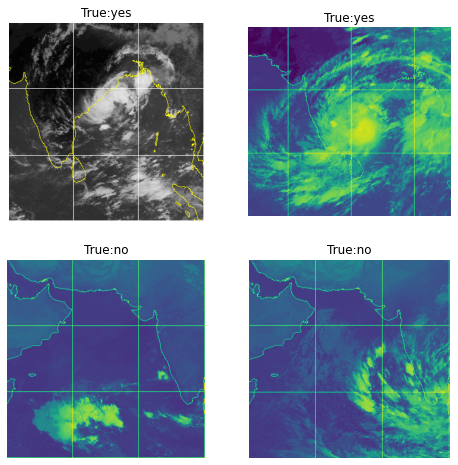

In [ ]:
show_few_images(2)

Training images

NO: 566
YES: 726
Total Training images: 1292
*************************************************


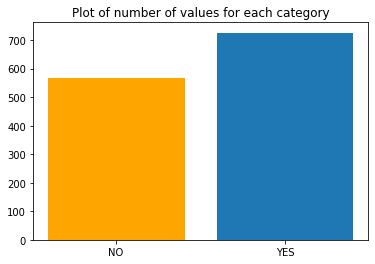


Validation images

NO: 142
YES: 182
Total Validation images: 324
*************************************************


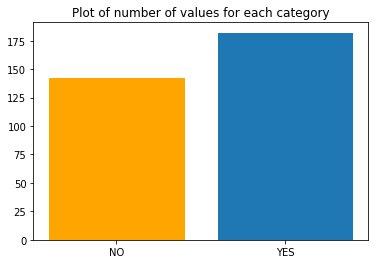

In [ ]:
print('Training images\n')
print('NO:', len(os.listdir(train+'/no')))
print('YES:', len(os.listdir(train+'/yes')))
print('Total Training images:', len(os.listdir(train+'/no')) + len(os.listdir(train+'/yes')))
print('*'*49)
bar_plot(train)
print('\nValidation images\n')
print('NO:', len(os.listdir(val+'/no')))
print('YES:', len(os.listdir(val+'/yes')))
print('Total Validation images:', len(os.listdir(val+'/no')) + len(os.listdir(val+'/yes')))
print('*'*49)
bar_plot(val)

In [ ]:
# hyperparameters config
width = 310
height = 310
train_batch_size = 2
val_batch_size = 1
model1_epoch = 15
model2_epoch = 15
xception_epoch = 15
vgg16_epoch = 15
own_epoch = 15

Data generator for train set included augmentation and processing (shear, zoom, horizontal_flip, rescale). For the test set only rescale should be made (we don't want to mess with new data - just predict its class).

In [ ]:
trainDataGen = ImageDataGenerator(rescale = 1./255, rotation_range = 5, zoom_range = 0.1, width_shift_range = 0.1)
validationDataGen = ImageDataGenerator(rescale = 1./255.)

It is important to put "shuffle" equal to False in test generator. Otherwise order of test pictures will be distorted by the function and predictions won't fit order expected by Kaggle checking system.

For test data batch size is 1 as we apply trained model to all test pictures without separating them by batches.

In [ ]:
train_generator = trainDataGen.flow_from_directory(train, target_size = (height, width), batch_size = train_batch_size, class_mode = 'binary', shuffle = True)
validation_generator = validationDataGen.flow_from_directory(val, target_size = (height, width), batch_size = val_batch_size, class_mode = 'binary', shuffle = False)

Found 1292 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


In [ ]:
from datetime import datetime
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

# **Model 1**

In [ ]:
model1 = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(height, width, 3)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dropout(0.5),
    
    Dense(512, activation=relu),
    Dropout(0.5),
    
    Dense(512, activation = relu),
    Dense(1, activation = sigmoid)
])

In [ ]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', f1])

In [ ]:
history = model1.fit(train_generator, epochs = model1_epoch, validation_data = validation_generator)

Epoch 1/15
646/646 [==============================] - 39s 59ms/step - loss: 0.4006 - acc: 0.8243 - f1: 0.6646 - val_loss: 0.3733 - val_acc: 0.8673 - val_f1: 0.5463
Epoch 2/15
646/646 [==============================] - 37s 57ms/step - loss: 0.3023 - acc: 0.8955 - f1: 0.7126 - val_loss: 0.1573 - val_acc: 0.9537 - val_f1: 0.5370
Epoch 3/15
646/646 [==============================] - 44s 68ms/step - loss: 0.1853 - acc: 0.9381 - f1: 0.7570 - val_loss: 0.1855 - val_acc: 0.9352 - val_f1: 0.5494
Epoch 4/15
646/646 [==============================] - 35s 54ms/step - loss: 0.1770 - acc: 0.9373 - f1: 0.7466 - val_loss: 0.1139 - val_acc: 0.9568 - val_f1: 0.5401
Epoch 5/15
646/646 [==============================] - 46s 72ms/step - loss: 0.1482 - acc: 0.9466 - f1: 0.7616 - val_loss: 0.0970 - val_acc: 0.9691 - val_f1: 0.5556
Epoch 6/15
646/646 [==============================] - 39s 61ms/step - loss: 0.1248 - acc: 0.9497 - f1: 0.7590 - val_loss: 0.1411 - val_acc: 0.9568 - val_f1: 0.5278
Epoch 7/15
646/6

Since we are evaluating the model, we should treat the validation set as if it was the test set. So we should sample the images in the validation set exactly once(if you are planning to evaluate, you need to change the batch size of the valid generator to 1 or something that exactly divides the total num of samples in validation set), but the order doesn’t matter so let “shuffle” be True as it was earlier.

In [ ]:
model1.evaluate(validation_generator)

324/324 [==============================] - 2s 6ms/step - loss: 0.0716 - acc: 0.9722 - f1: 0.5432


[0.07155929505825043, 0.9722222089767456, 0.5432098507881165]

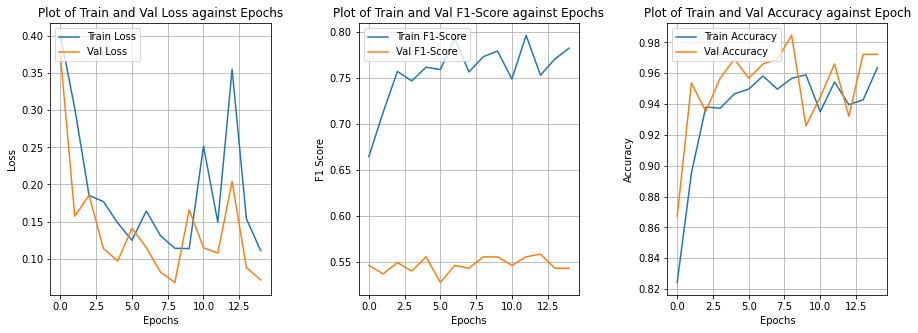

In [ ]:
plot_performance_metrics(history)

You need to reset the test_generator before whenever you call the predict_generator. This is important, if you forget to reset the test_generator you will get outputs in a weird order.

In [ ]:
validation_generator.reset()
prediction = model1.predict(validation_generator, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 2s 5ms/step


now predicted_class_indices has the predicted labels, but you can’t simply tell what the predictions are, because all you can see is numbers like 0,1,4,1,0,6…
You need to map the predicted labels with their unique ids such as filenames to find out what you predicted for which image.

True Positive  (TP) =  139
False Positive (FP) =  3
False Negative (FN) =  6
True Negative  (TN) =  176
--------------------------
Precision Score: 97.89%
Recall Score: 95.86%
F1 Score: 96.86%




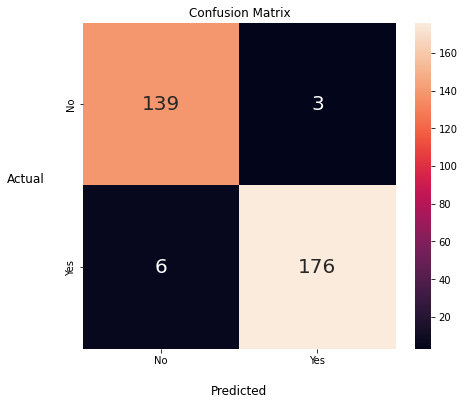

In [ ]:
plot_confusion_matrix(prediction, actual_class)

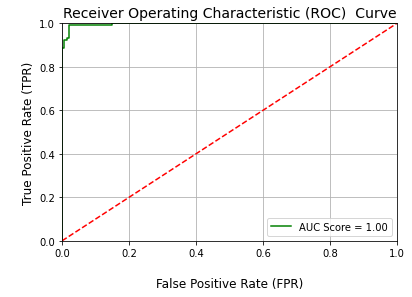


 Classification Report: 

               precision    recall  f1-score   support

          no       0.96      0.98      0.97       142
         yes       0.98      0.97      0.98       182

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["no", "yes"]))
print('='*55)

# **Model 2**

In [ ]:
model2 = Sequential([
                     Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(width, height, 3)),
                     Conv2D(16, (3, 3), padding="same", activation='relu'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(32, (3, 3), activation='relu', padding="same"),
                     Conv2D(32, (3, 3), padding="same", activation='relu'),
                     MaxPooling2D(pool_size=(2, 2)),
                     BatchNormalization(),
                     Conv2D(64, (3, 3), activation='relu', padding="same"),
                     Conv2D(64, (3, 3), padding="same", activation='relu'),
                     MaxPooling2D(pool_size=(2, 2)),
                     BatchNormalization(),
                     Dropout(0.2),
                     Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"),
                     Conv2D(96, (3, 3), padding="valid", activation='relu'),
                     MaxPooling2D(pool_size=(2, 2)),
                     BatchNormalization(),
                     Dropout(0.3),
                     Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"),
                     Conv2D(128, (3, 3), padding="valid", activation='relu'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Flatten(),
                     Dense(64, activation='relu'),
                     BatchNormalization(),
                     Dense(1 , activation='sigmoid'),
])

In [ ]:
model2.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['acc', f1]) 

In [ ]:
history = model2.fit(train_generator, epochs = model2_epoch, validation_data = validation_generator)

Epoch 1/15
646/646 [==============================] - 38s 55ms/step - loss: 0.6293 - acc: 0.6625 - f1: 0.6388 - val_loss: 0.4164 - val_acc: 0.8056 - val_f1: 0.5494
Epoch 2/15
646/646 [==============================] - 35s 54ms/step - loss: 0.6388 - acc: 0.6486 - f1: 0.6311 - val_loss: 1.6318 - val_acc: 0.3642 - val_f1: 0.3025
Epoch 3/15
646/646 [==============================] - 35s 54ms/step - loss: 0.5937 - acc: 0.6958 - f1: 0.6734 - val_loss: 0.3494 - val_acc: 0.8549 - val_f1: 0.5340
Epoch 4/15
646/646 [==============================] - 35s 54ms/step - loss: 0.5250 - acc: 0.7353 - f1: 0.7183 - val_loss: 0.3517 - val_acc: 0.8642 - val_f1: 0.5432
Epoch 5/15
646/646 [==============================] - 35s 54ms/step - loss: 0.6618 - acc: 0.6076 - f1: 0.6047 - val_loss: 0.7174 - val_acc: 0.5710 - val_f1: 0.5494
Epoch 6/15
646/646 [==============================] - 35s 54ms/step - loss: 0.6748 - acc: 0.5836 - f1: 0.5820 - val_loss: 1.0037 - val_acc: 0.6358 - val_f1: 0.3580
Epoch 7/15
646/6

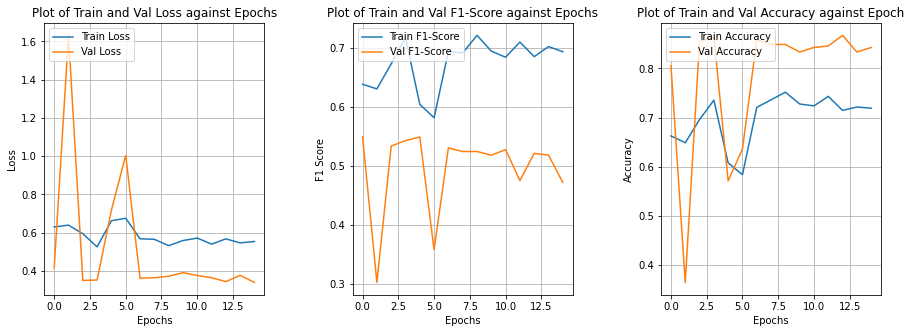

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = model1.predict(validation_generator, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 2s 6ms/step


True Positive  (TP) =  139
False Positive (FP) =  3
False Negative (FN) =  6
True Negative  (TN) =  176
--------------------------
Precision Score: 97.89%
Recall Score: 95.86%
F1 Score: 96.86%




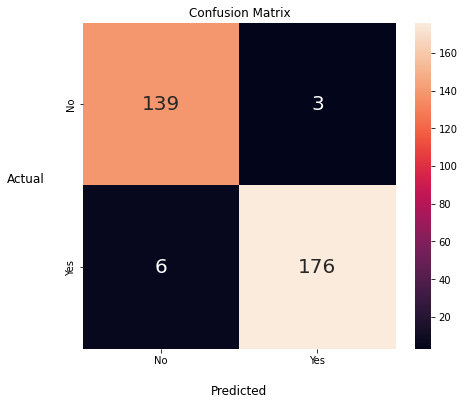

In [ ]:
plot_confusion_matrix(prediction, actual_class)

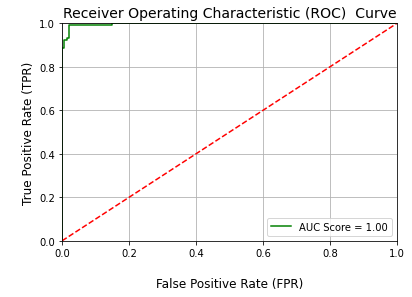


 Classification Report: 

               precision    recall  f1-score   support

          No       0.96      0.98      0.97       142
         Yes       0.98      0.97      0.98       182

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **Xception Net**

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310,310,3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dense(1, activation=sigmoid)(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
xception_final_model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [f1, 'acc'])

In [ ]:
history = xception_final_model.fit(train_generator, epochs = xception_epoch, verbose = 1, validation_data = validation_generator)

Epoch 1/15
646/646 [==============================] - 90s 129ms/step - loss: 0.6633 - f1: 0.6569 - acc: 0.7330 - val_loss: 0.4992 - val_f1: 0.3765 - val_acc: 0.7963
Epoch 2/15
646/646 [==============================] - 82s 127ms/step - loss: 0.4666 - f1: 0.7198 - acc: 0.8785 - val_loss: 0.3954 - val_f1: 0.4907 - val_acc: 0.9043
Epoch 3/15
646/646 [==============================] - 81s 125ms/step - loss: 0.3551 - f1: 0.7394 - acc: 0.9033 - val_loss: 0.2385 - val_f1: 0.5370 - val_acc: 0.9506
Epoch 4/15
646/646 [==============================] - 81s 125ms/step - loss: 0.4188 - f1: 0.7688 - acc: 0.9071 - val_loss: 6.4119 - val_f1: 0.5586 - val_acc: 0.9012
Epoch 5/15
646/646 [==============================] - 81s 125ms/step - loss: 0.4306 - f1: 0.7539 - acc: 0.9180 - val_loss: 0.1992 - val_f1: 0.5556 - val_acc: 0.9414
Epoch 6/15
646/646 [==============================] - 81s 125ms/step - loss: 0.7136 - f1: 0.6821 - acc: 0.8522 - val_loss: 1.4522 - val_f1: 0.5463 - val_acc: 0.9259
Epoch 7/15

In [ ]:
xception_final_model.evaluate(validation_generator)

324/324 [==============================] - 5s 15ms/step - loss: 0.3481 - f1: 0.5525 - acc: 0.9228


[0.34809502959251404, 0.5524690747261047, 0.9228395223617554]

In [ ]:
xception_final_model.save('/content/drive/MyDrive/binary_xception_model.hdf5')

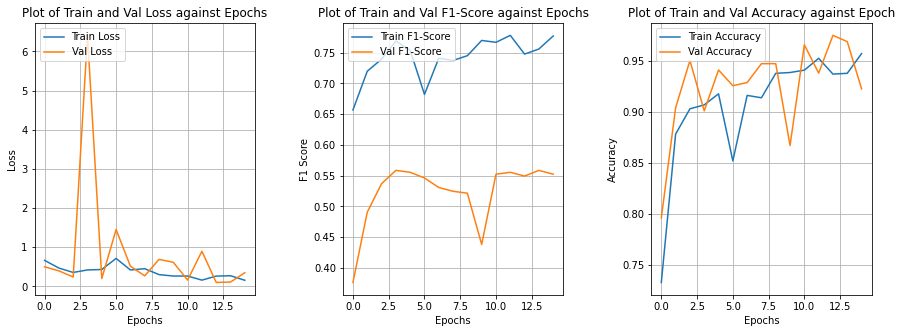

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = xception_final_model.predict(validation_generator, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 6s 14ms/step


True Positive  (TP) =  120
False Positive (FP) =  22
False Negative (FN) =  3
True Negative  (TN) =  179
--------------------------
Precision Score: 84.51%
Recall Score: 97.56%
F1 Score: 90.57%




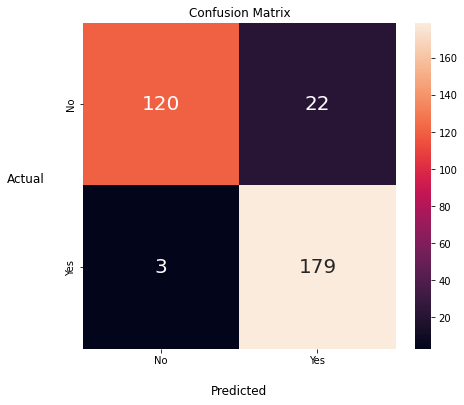

In [ ]:
plot_confusion_matrix(prediction, actual_class)

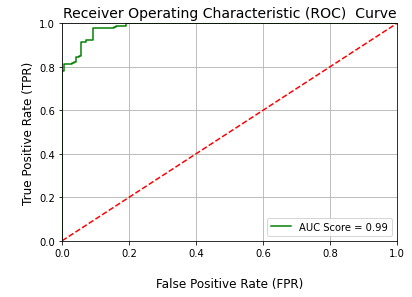


 Classification Report: 

               precision    recall  f1-score   support

          No       0.98      0.85      0.91       142
         Yes       0.89      0.98      0.93       182

    accuracy                           0.92       324
   macro avg       0.93      0.91      0.92       324
weighted avg       0.93      0.92      0.92       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **VGG-16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (height, width, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'sigmoid')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_final_model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [f1, 'acc'])

In [ ]:
history = vgg16_final_model.fit(train_generator, epochs = vgg16_epoch, validation_data = validation_generator)

Epoch 1/15
646/646 [==============================] - 780s 1s/step - loss: 0.3657 - f1: 0.6785 - acc: 0.8375 - val_loss: 0.6706 - val_f1: 0.2500 - val_acc: 0.6883
Epoch 2/15
646/646 [==============================] - 40s 62ms/step - loss: 0.2566 - f1: 0.7136 - acc: 0.8893 - val_loss: 0.3616 - val_f1: 0.4043 - val_acc: 0.8426
Epoch 3/15
646/646 [==============================] - 40s 62ms/step - loss: 0.2146 - f1: 0.7343 - acc: 0.9048 - val_loss: 0.2230 - val_f1: 0.4722 - val_acc: 0.9012
Epoch 4/15
646/646 [==============================] - 40s 62ms/step - loss: 0.1588 - f1: 0.7554 - acc: 0.9404 - val_loss: 0.1641 - val_f1: 0.4907 - val_acc: 0.9228
Epoch 5/15
646/646 [==============================] - 40s 63ms/step - loss: 0.1497 - f1: 0.7606 - acc: 0.9373 - val_loss: 0.2945 - val_f1: 0.4444 - val_acc: 0.8827
Epoch 6/15
646/646 [==============================] - 40s 62ms/step - loss: 0.1299 - f1: 0.7755 - acc: 0.9551 - val_loss: 0.1672 - val_f1: 0.4907 - val_acc: 0.9259
Epoch 7/15
646/64

In [ ]:
vgg16_final_model.evaluate(validation_generator)

324/324 [==============================] - 6s 18ms/step - loss: 0.5911 - f1: 0.3241 - acc: 0.7623


[0.5911175608634949, 0.32407405972480774, 0.7623456716537476]

In [ ]:
vgg16_final_model.save('/content/drive/MyDrive/binary_vgg_model.hdf5')

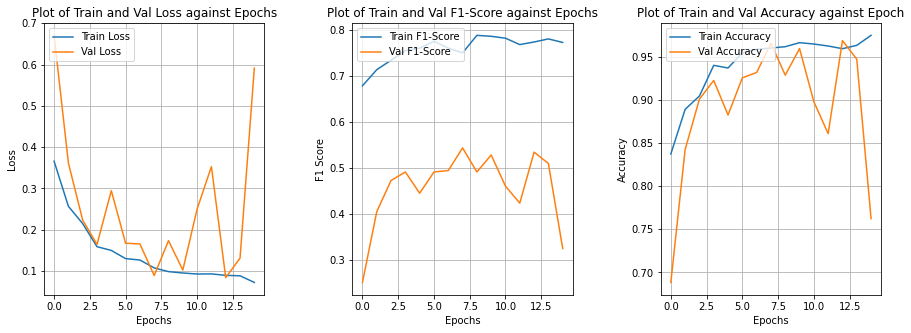

In [ ]:
plot_performance_metrics(history)

True Positive  (TP) =  142
False Positive (FP) =  0
False Negative (FN) =  77
True Negative  (TN) =  105
--------------------------
Precision Score: 100.0%
Recall Score: 64.84%
F1 Score: 78.67%




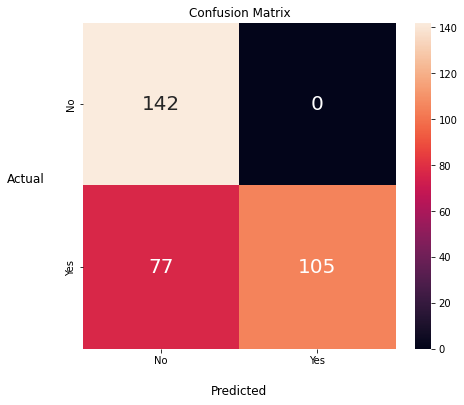

In [ ]:
validation_generator.reset()
prediction = vgg16_final_model.predict(validation_generator)
actual_class = validation_generator.classes
plot_confusion_matrix(prediction, actual_class)

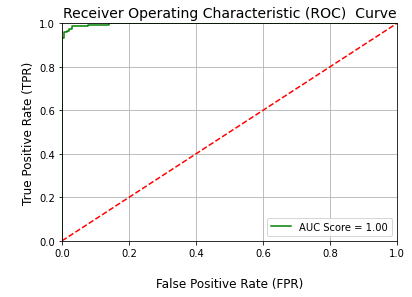


 Classification Report: 

               precision    recall  f1-score   support

          No       0.65      1.00      0.79       142
         Yes       1.00      0.58      0.73       182

    accuracy                           0.76       324
   macro avg       0.82      0.79      0.76       324
weighted avg       0.85      0.76      0.76       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **Own Model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (width, height, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(units = 512, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [f1, 'acc']) 

In [ ]:
own_model = model.fit(train_generator, epochs = own_epoch, validation_data = validation_generator)

Epoch 1/15
646/646 [==============================] - 37s 55ms/step - loss: 0.5458 - f1: 0.5893 - acc: 0.7268 - val_loss: 0.1807 - val_f1: 0.5340 - val_acc: 0.9506
Epoch 2/15
646/646 [==============================] - 34s 53ms/step - loss: 0.1953 - f1: 0.7405 - acc: 0.9327 - val_loss: 0.0936 - val_f1: 0.5370 - val_acc: 0.9599
Epoch 3/15
646/646 [==============================] - 35s 54ms/step - loss: 0.1485 - f1: 0.7611 - acc: 0.9528 - val_loss: 0.4583 - val_f1: 0.4691 - val_acc: 0.9074
Epoch 4/15
646/646 [==============================] - 34s 53ms/step - loss: 0.1186 - f1: 0.7822 - acc: 0.9659 - val_loss: 0.0515 - val_f1: 0.5494 - val_acc: 0.9784
Epoch 5/15
646/646 [==============================] - 34s 52ms/step - loss: 0.1214 - f1: 0.7812 - acc: 0.9590 - val_loss: 0.4071 - val_f1: 0.4599 - val_acc: 0.8951
Epoch 6/15
646/646 [==============================] - 34s 52ms/step - loss: 0.1038 - f1: 0.7730 - acc: 0.9613 - val_loss: 0.1573 - val_f1: 0.5093 - val_acc: 0.9475
Epoch 7/15
646/6

In [ ]:
model.evaluate(validation_generator)

324/324 [==============================] - 2s 7ms/step - loss: 0.0570 - f1: 0.5432 - acc: 0.9815


[0.05702393129467964, 0.5432098507881165, 0.9814814925193787]

In [ ]:
model.save("/content/drive/MyDrive/binary_own_model.hdf5")

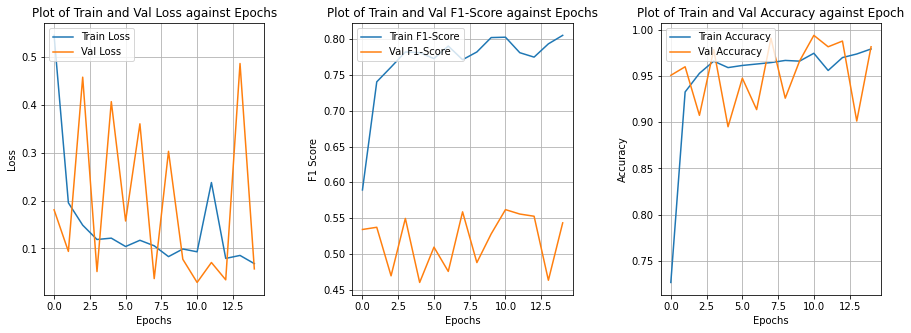

In [ ]:
plot_performance_metrics(own_model)

True Positive  (TP) =  142
False Positive (FP) =  0
False Negative (FN) =  6
True Negative  (TN) =  176
--------------------------
Precision Score: 100.0%
Recall Score: 95.95%
F1 Score: 97.93%




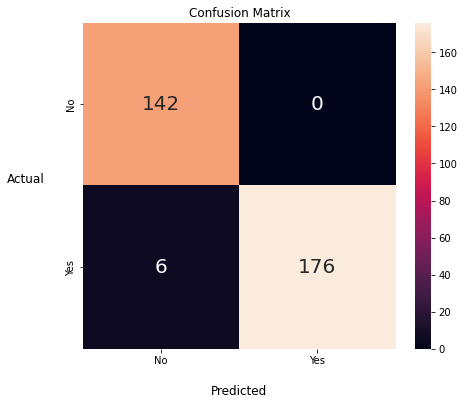

In [ ]:
validation_generator.reset()
prediction = model.predict(validation_generator)
actual_class = validation_generator.classes
plot_confusion_matrix(prediction, actual_class)

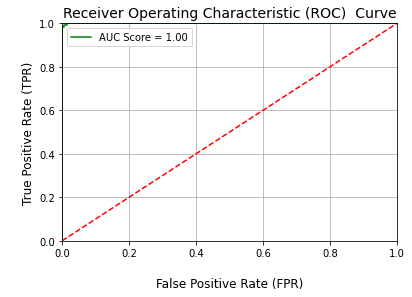


 Classification Report: 

               precision    recall  f1-score   support

          No       0.96      1.00      0.98       142
         Yes       1.00      0.97      0.98       182

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **Ensembling**

In [ ]:
vgg_best_model = load_model('/content/drive/MyDrive/binary_vgg_model.hdf5', custom_objects = {'f1':f1})
xception_best_model = load_model('/content/drive/MyDrive/binary_xception_model.hdf5', custom_objects = {'f1':f1})
own_best_model = load_model('/content/drive/MyDrive/binary_own_model.hdf5', custom_objects = {'f1':f1})

In [ ]:
from collections import Counter
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

In [ ]:
true_value = []
combined_model_pred = []
vgg_pred = []
xception_pred = []
own_model_pred = []
validation_generator.reset()

for folder in os.listdir(val):
    test_image_ids = os.listdir(os.path.join(val, folder))
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(val, folder, image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(height, width))
        img_normalized = img/255
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #Xception
        xception_image_prediction = np.argmax(xception_best_model.predict(np.array([img_normalized])))
        xception_pred.append(xception_image_prediction)

        #own
        own_model_prediction = np.argmax(own_best_model.predict(np.array([img_normalized])))
        own_model_pred.append(own_model_prediction)
        
        #giving own model high priority if they all predict something different
        image_prediction = mode([own_model_prediction, vgg16_image_prediction])                                
        combined_model_pred.append(image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.4382716049382716
              precision    recall  f1-score   support

          no       0.44      1.00      0.61       142
         yes       0.00      0.00      0.00       182

    accuracy                           0.44       324
   macro avg       0.22      0.50      0.30       324
weighted avg       0.19      0.44      0.27       324



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


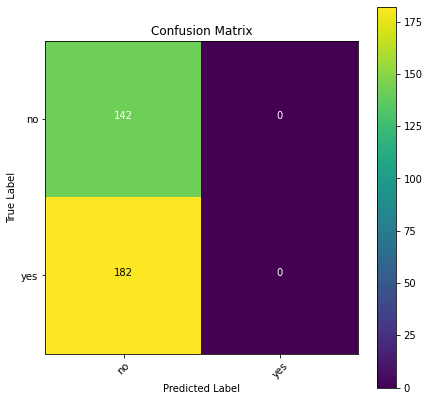

In [ ]:
combined_model_pred = [c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)